#### Week 1

Code to complete homework for Week 1 - Introduction of MLOps zoomcamp

Homework questions are [here](https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2024/01-intro/homework.md)

In [1]:
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso 
from sklearn.metrics import root_mean_squared_error

Matplotlib is building the font cache; this may take a moment.


In [4]:
# Experiment tracking
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi_experiment")

<Experiment: artifact_location='/home/ubuntu/mlops/notebooks/mlruns/1', creation_time=1716820670098, experiment_id='1', last_update_time=1716820670098, lifecycle_stage='active', name='nyc_taxi_experiment', tags={}>

In [2]:
df1 = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet", engine='pyarrow')
df2 = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet", engine='pyarrow')

#### Question 1

In [6]:
df1.shape

(3066766, 19)

#### Question 2

In [10]:
# Calculate duration
df1['duration'] =df1["tpep_dropoff_datetime"] -  df1["tpep_pickup_datetime"] 
df1["duration"] = df1["duration"].dt.total_seconds().div(60).astype(float)
df1["duration"].std()

9.939385620151036

#### Question 3

In [11]:
original_size = df1.shape[0]
df1 = df1[(df1["duration"] <= 60)
                 & (df1["duration"] >= 1)]
new_size = df1.shape[0]
frac_remain = new_size / original_size
print(f"{round(frac_remain*100, 0)}% of records remain after removing outliers.")

100.0% of records remain after removing outliers.


#### Question 4

In [12]:
cat_feat = ["PULocationID", "DOLocationID"]
num_feat = ['trip_distance']
df1[cat_feat] = df1[cat_feat].astype(str)
train_dicts = df1[cat_feat+num_feat].to_dict(orient="records")

In [13]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [51]:
print(f"The feature matrix has {X_train.shape[1]} columns.")

The feature matrix has 516 columns.


#### Question 5

In [17]:
y_train = df1["duration"].values
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

In [53]:
y_pred

array([11.47402265, 10.94671062, 11.36752529, ..., 11.66834426,
       12.70016582, 11.60929473])

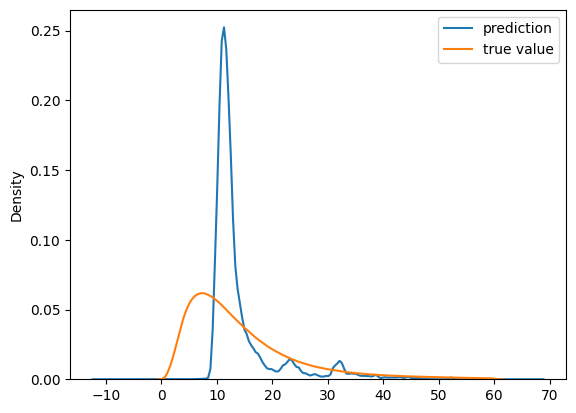

In [54]:
sns.kdeplot(y_pred, label = "prediction")
sns.kdeplot(y_train, label = "true value") 
plt.legend()
plt.show()

In [55]:
root_mean_squared_error(y_train, y_pred)

7.65839726314459

#### Question 6

In [14]:
# Prepare Feb dataset
df2['duration'] = df2["tpep_dropoff_datetime"] -  df2["tpep_pickup_datetime"] 
df2["duration"] = df2["duration"].dt.total_seconds().div(60).astype(float)

df2 = df2[(df2["duration"] <= 60)
                 & (df2["duration"] >= 1)]

df2[cat_feat] = df2[cat_feat].astype(str)
test_dicts = df2[cat_feat + num_feat].to_dict(orient="records")
X_test = dv.transform(test_dicts)

In [57]:
X_test.shape

(2855951, 516)

In [19]:
y_test = df2["duration"].values
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
root_mean_squared_error(y_test, y_test_pred)


7.820259863004852

### Saving model


In [ ]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)